In [2]:
%load_ext autoreload
%autoreload 2

# PriorVAE: Comparisons of scaling

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
from jax import random
from numpyro.infer import Predictive

from plotting.helpers import pretty_label, pretty_loss_fn_name
from plotting.plots import (plot_draws_hpdi, plot_times_graph,
                            plot_times_matrix, plot_training)
from reusable.gp import OneDGP
from reusable.util import (gen_file_name, get_decoder_params, load_args,
                           load_scores, load_training_history,
                           load_training_state, update_args_11)
from reusable.vae import VAE, vae_sample

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def plot_experiment(experiment, count):
    temp_args = load_args("11", count, experiment)


    gp_draws = plot_gp_predictive(rng_key_gp, x=temp_args["x"], gp_kernel=temp_args["gp_kernel"], jitter=1e-5)["y"]

    exp_args = temp_args[experiment]

    aL = len(exp_args["Arange"])
    bL = len(exp_args["Brange"])


    for loss_fn in temp_args["loss_fns"]:
        pretty_lf = pretty_loss_fn_name(loss_fn)

        prettyAdesc = pretty_label(exp_args["Adesc"])
        prettyBdesc = pretty_label(exp_args["Bdesc"])
        

        training_fig, training_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
        training_fig.suptitle(
            f"{experiment}: row:{prettyAdesc}, col:{prettyBdesc}Test/train for loss fn {pretty_lf}",
            fontsize=40,
        )

        comp_fig, comp_axs = plt.subplots(nrows=aL + 1, ncols=bL, figsize=(bL * 6, aL * 5 + 5))
        comp_fig.suptitle(
            f"{experiment}: row:{prettyAdesc}, col:{prettyBdesc} comparison plots for {pretty_lf}",
            fontsize=40,
        )

        plot_draws_hpdi(gp_draws, temp_args["x"], f"GP draws", "$y=f_{GP}(x)$", "GP", ax=comp_axs[0, 0])

        for j in range(1, len(exp_args["Brange"])):
            comp_axs[0, j].remove()

        for i, a in enumerate(exp_args["Arange"]):
            for j, b in enumerate(exp_args["Brange"]):
                args =  load_args("11", count, experiment)

                args = update_args_11(args, args[experiment], i, j)

                index = i + j * aL
                try:
                    metrics_history = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))

                    
                    plot_training(
                        metrics_history["test_loss"],
                        metrics_history["train_loss"],
                        f"Test/train loss for {prettyAdesc}={a}, {prettyBdesc}={b}",
                        "loss",
                        training_axs[i, j],
                    )

                    dummy = VAE(
                        hidden_dim1=args["hidden_dim1"],
                        hidden_dim2=args["hidden_dim2"],
                        latent_dim=args["latent_dim"],
                        out_dim=args["n"],
                        conditional=False,
                    )
                    dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

                    decoder_params = get_decoder_params(load_training_state("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"), dummy_params))

                  
                    plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
                    vae_draws = plot_vae_predictive(
                        rng_key_predict,
                        hidden_dim1=args["hidden_dim1"],
                        hidden_dim2=args["hidden_dim2"],
                        latent_dim=args["latent_dim"],
                        out_dim=args["n"],
                        decoder_params=decoder_params,
                    )["f"]

                    plot_draws_hpdi(
                        vae_draws,
                        args["x"],
                        f"{prettyAdesc}={a}, {prettyBdesc}={b}",
                        "$y=f_{VAE}(x)$",
                        "VAE",
                        ax=comp_axs[i + 1, j],
                    )

                except FileNotFoundError:
                    print(f"Failed to load a={a}, b={b}")

        comp_fig.savefig(f"./gen_plots/11/11_{experiment}_{count}_{loss_fn}_draws.pdf")
        training_fig.savefig(f"./gen_plots/11/11_{experiment}_{count}_{loss_fn}_training.pdf")


# Grid of training plots

In [5]:

def plot_experiment_times(experiment, count):
    temp_args = load_args("11", count, experiment)


    exp_args = temp_args[experiment]
    aL = len(exp_args["Arange"])

    for loss_fn in temp_args["loss_fns"]:
        print(f"{loss_fn} ==================================")
        pretty_lf = pretty_loss_fn_name(loss_fn)

        prettyAdesc = pretty_label(exp_args["Adesc"])
        prettyBdesc = pretty_label(exp_args["Bdesc"])

        histories = []


        for i, a in enumerate(exp_args["Arange"]):
            i_hists = []
            for j, b in enumerate(exp_args["Brange"]):
                args =  load_args("11", count, experiment)

                args = update_args_11(args, args[experiment], i, j)

                index = i + j * aL
            

                try:
                    h = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))
                    
                    if "train_loss" in h and loss_fn != "RCL+KLD" and jnp.any(jnp.isnan(h["train_loss"])):
                        print(index, h["train_loss"])
                    
                    i_hists.append(h)

                except FileNotFoundError:
                    i_hists.append({"interrupted": True})
                    print(f"Failed to load a={a}, b={b}")
            histories.append(i_hists)
            
        full_times = onp.array([[h["epoch_times"][-1] if "epoch_times" in h else float('nan') for h in hs] for hs in histories]) / 60
        onp.savetxt(f"./gen_plots/11/11_{experiment}_{loss_fn}_data.csv", full_times)

        interrupted = onp.array([["interrupted" in h for h in hs] for hs in histories])
        full_epochs = onp.array([[len(h["epoch_times"])if "epoch_times" in h else float('nan') for h in hs] for hs in histories])

        masked_times = onp.ma.array(full_times, mask=interrupted)

        # matrix of A x B, showing times
        plot_times_matrix(
            masked_times,
            exp_args["Arange"],
            exp_args["Brange"],
            prettyAdesc,
            prettyBdesc,
            f"{experiment}: {pretty_lf}",
            save_path=f"./gen_plots/11/11_{experiment}_{loss_fn}_matrix.png",
        )
        # graph of x=A, y=time, curve per B

        plot_times_graph(
            masked_times,
            exp_args["Brange"],
            exp_args["Arange"],
            prettyBdesc,
            prettyAdesc,
            f"{pretty_lf}",
            save_path=f"./gen_plots/11/11_{experiment}_{loss_fn}_timeVb.png",
        )
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            masked_times.T,
            exp_args["Arange"],
            exp_args["Brange"],
            prettyAdesc,
            prettyBdesc,
            f"{pretty_lf}",
            save_path=f"./gen_plots/11/11_{experiment}_{loss_fn}_timeVa.png",
        )

        # same graphs, but just increase from initial:
        initial_times = full_times[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[1]))

        plot_times_graph(
            onp.ma.subtract(masked_times, initial_times),
            exp_args["Brange"],
            exp_args["Arange"],
            prettyBdesc,
            prettyAdesc,
            f"{pretty_lf}",
            is_relative=True,
            save_path=f"./gen_plots/11/11_{experiment}_{loss_fn}_timeVb_change.png",
        )

        initial_times = full_times.T[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[0]))
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            onp.ma.subtract(masked_times.T, initial_times),
            exp_args["Arange"],
            exp_args["Brange"],
            prettyAdesc,
            prettyBdesc,
            f"{pretty_lf}",
            is_relative=True,
            save_path=f"./gen_plots/11/11_{experiment}_{loss_fn}_timeVa_change.png",
        )


In [69]:

#plot_experiment_times("exp5", "1")
plot_experiment_times("exp6", "1")
#plot_experiment_times("exp7", "1")
#plot_experiment_times("exp8", "1")
#plot_experiment_times("exp9", "1")


RCL+KLD ==================================
0.01RCL+KLD+10mmd_rbf_sum-4.0 ==================================
35 [1.1854509 3.9443424 4.6395254 2.7444055 4.873695  7.1205297 5.0125628
 3.5791414 2.07589   3.9081483 1.7547203 3.9741778 2.8863554 3.720124
 3.6312344 3.4721572 2.8996556 3.4461102 2.620705  3.4503453 2.9310899
 2.927493  3.4877894 3.533277  2.7500036 2.6656594 3.1162105 2.7494824
 2.4844346 1.9003462 3.751486  2.6676333 2.7337842 2.7726007 3.219822
 2.8675685 2.6101696 4.9577494 2.8495674 2.4215631 3.2112687 3.2906039
 4.7478805 4.7765975 6.4524126 2.742931  4.318053  3.4663491 3.3981478
 2.868888  3.0274842 3.1335876 3.8878646 3.7825203 5.122633  4.2498045
 3.0482624 3.0008495 3.0629728       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       na

WARNING! all draws were NaN for title batch size=50, training batches=2000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=50, training batches=4000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=100, training batches=2000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=100, training batches=4000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=200, training batches=1000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=200, training batches=2000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=200, training batches=4000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=400, training batches=1000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=400, training batches=2000, ylabel $y=f_{VAE}(x)$
WARNING! all draws were NaN for title batch size=400, training batches=4000, ylabel $y=f_{VAE}(x)$
WARNING! all

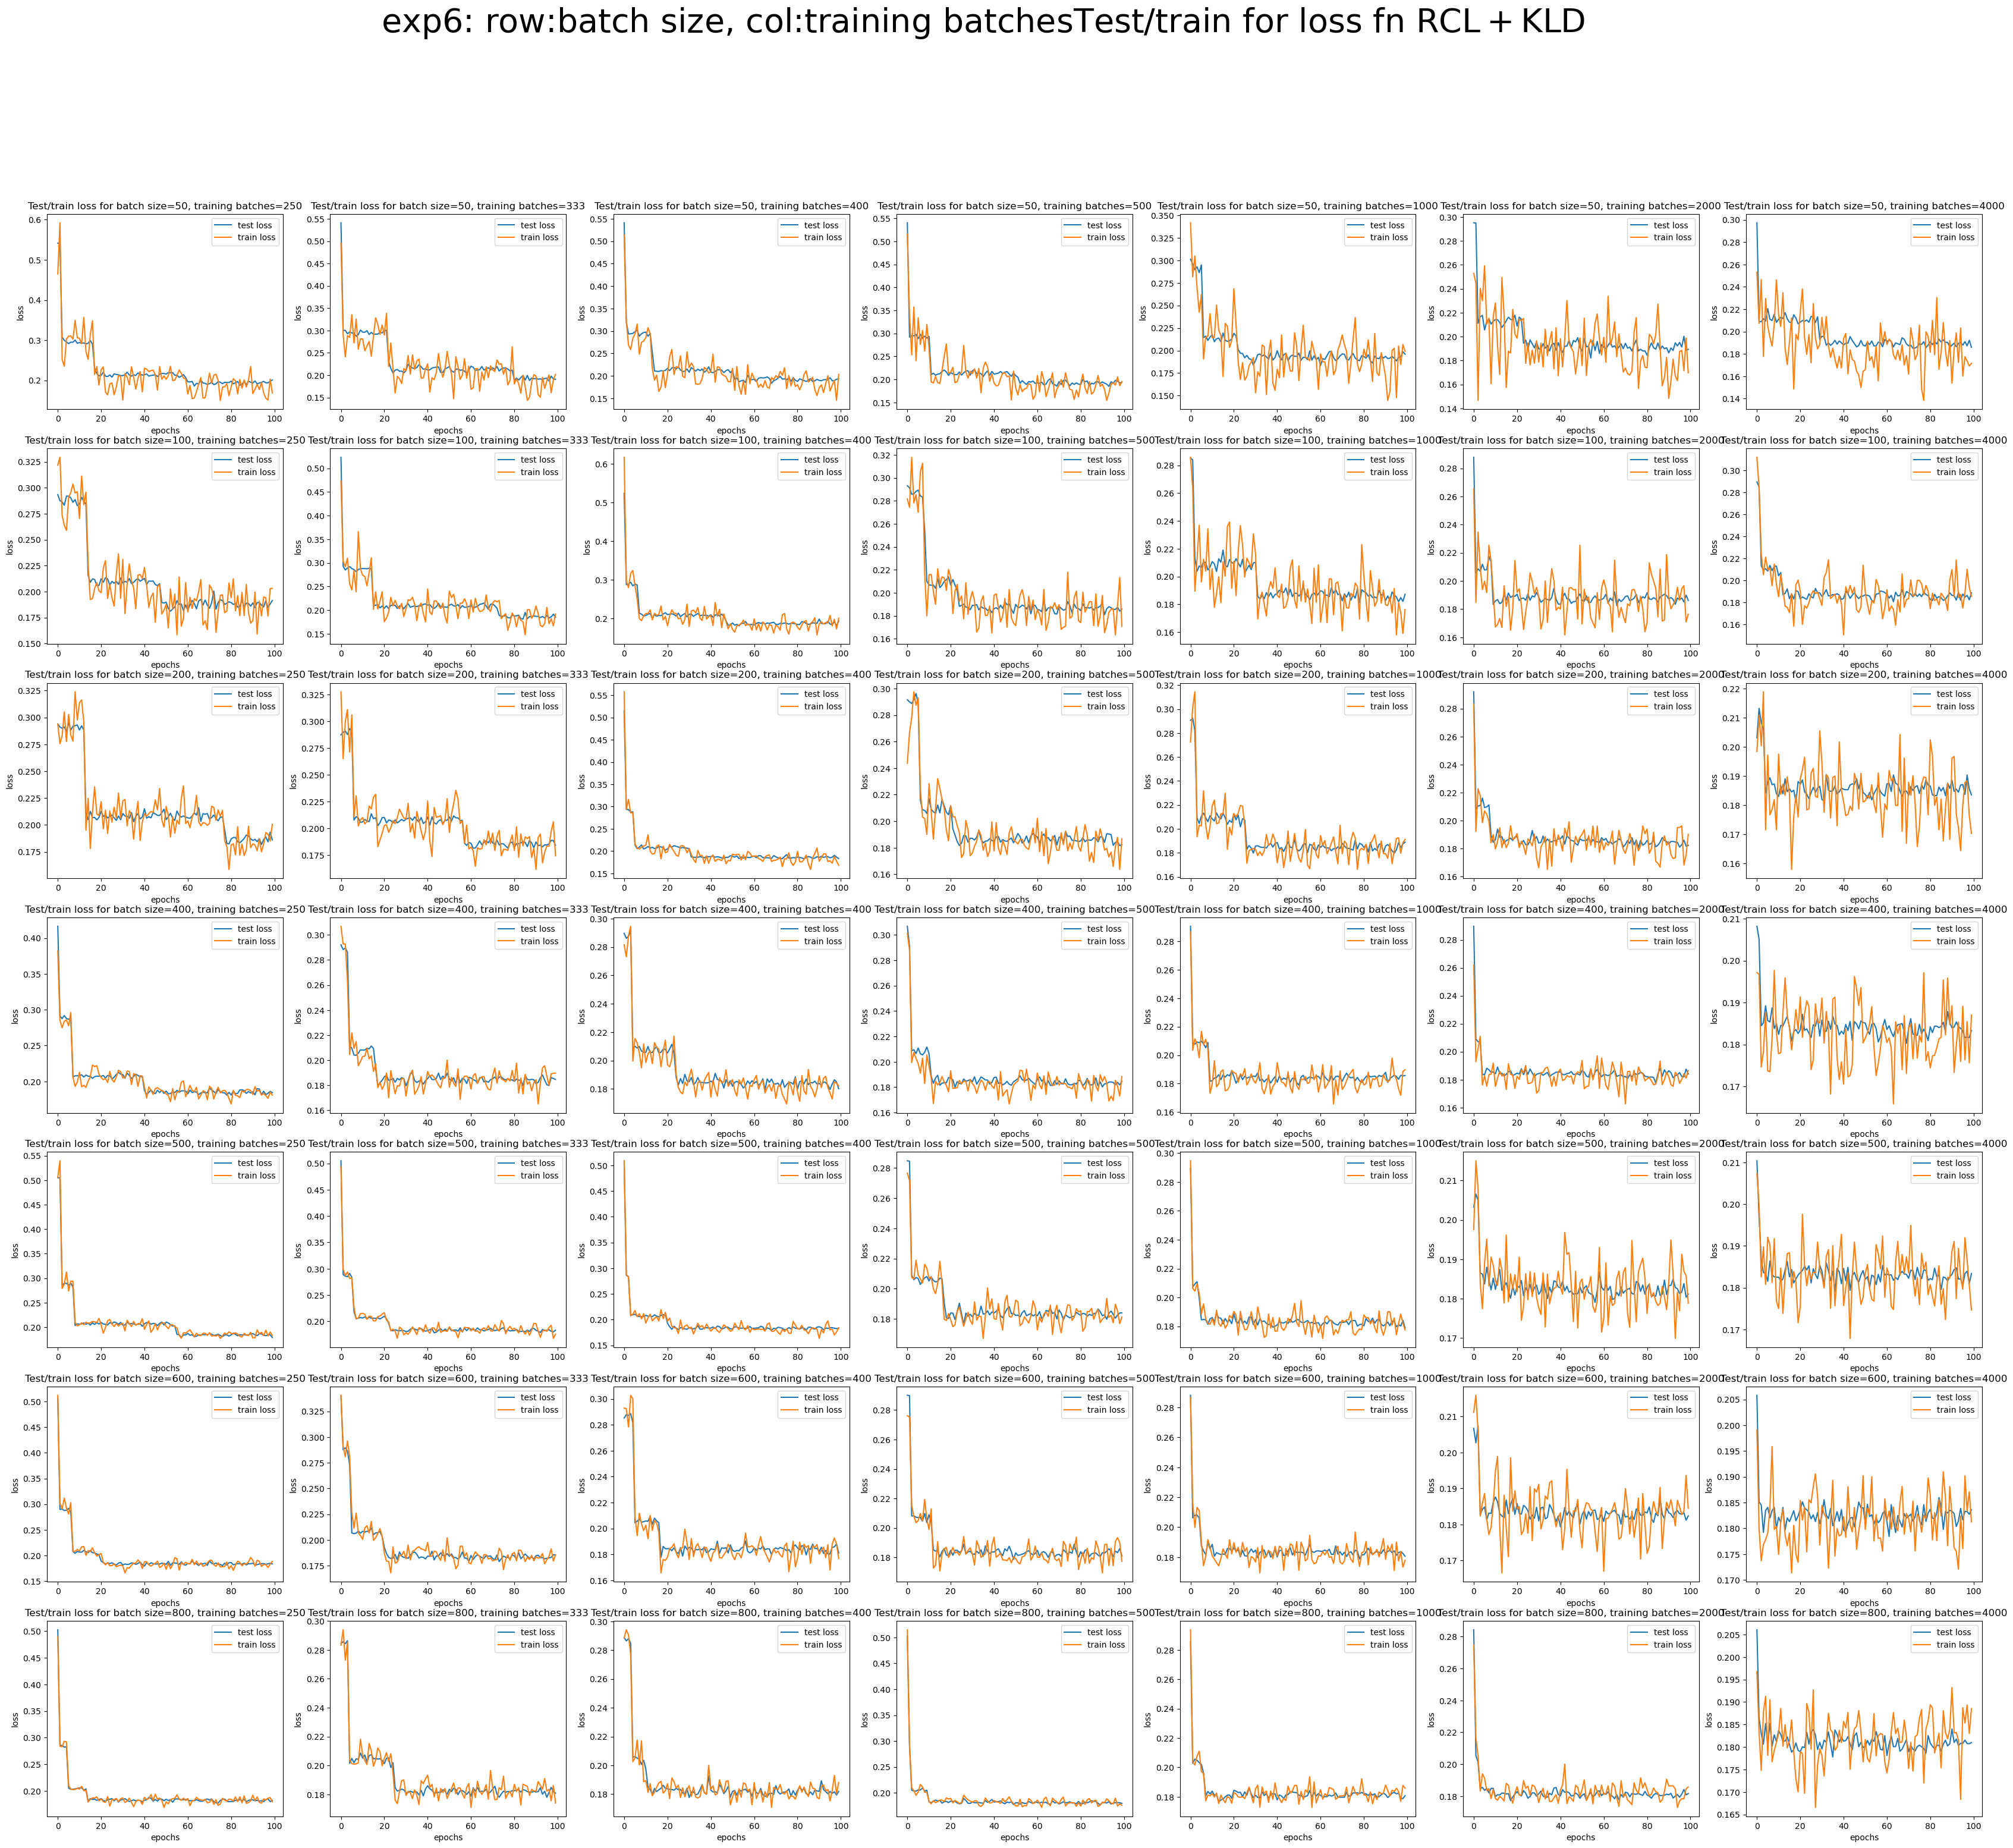

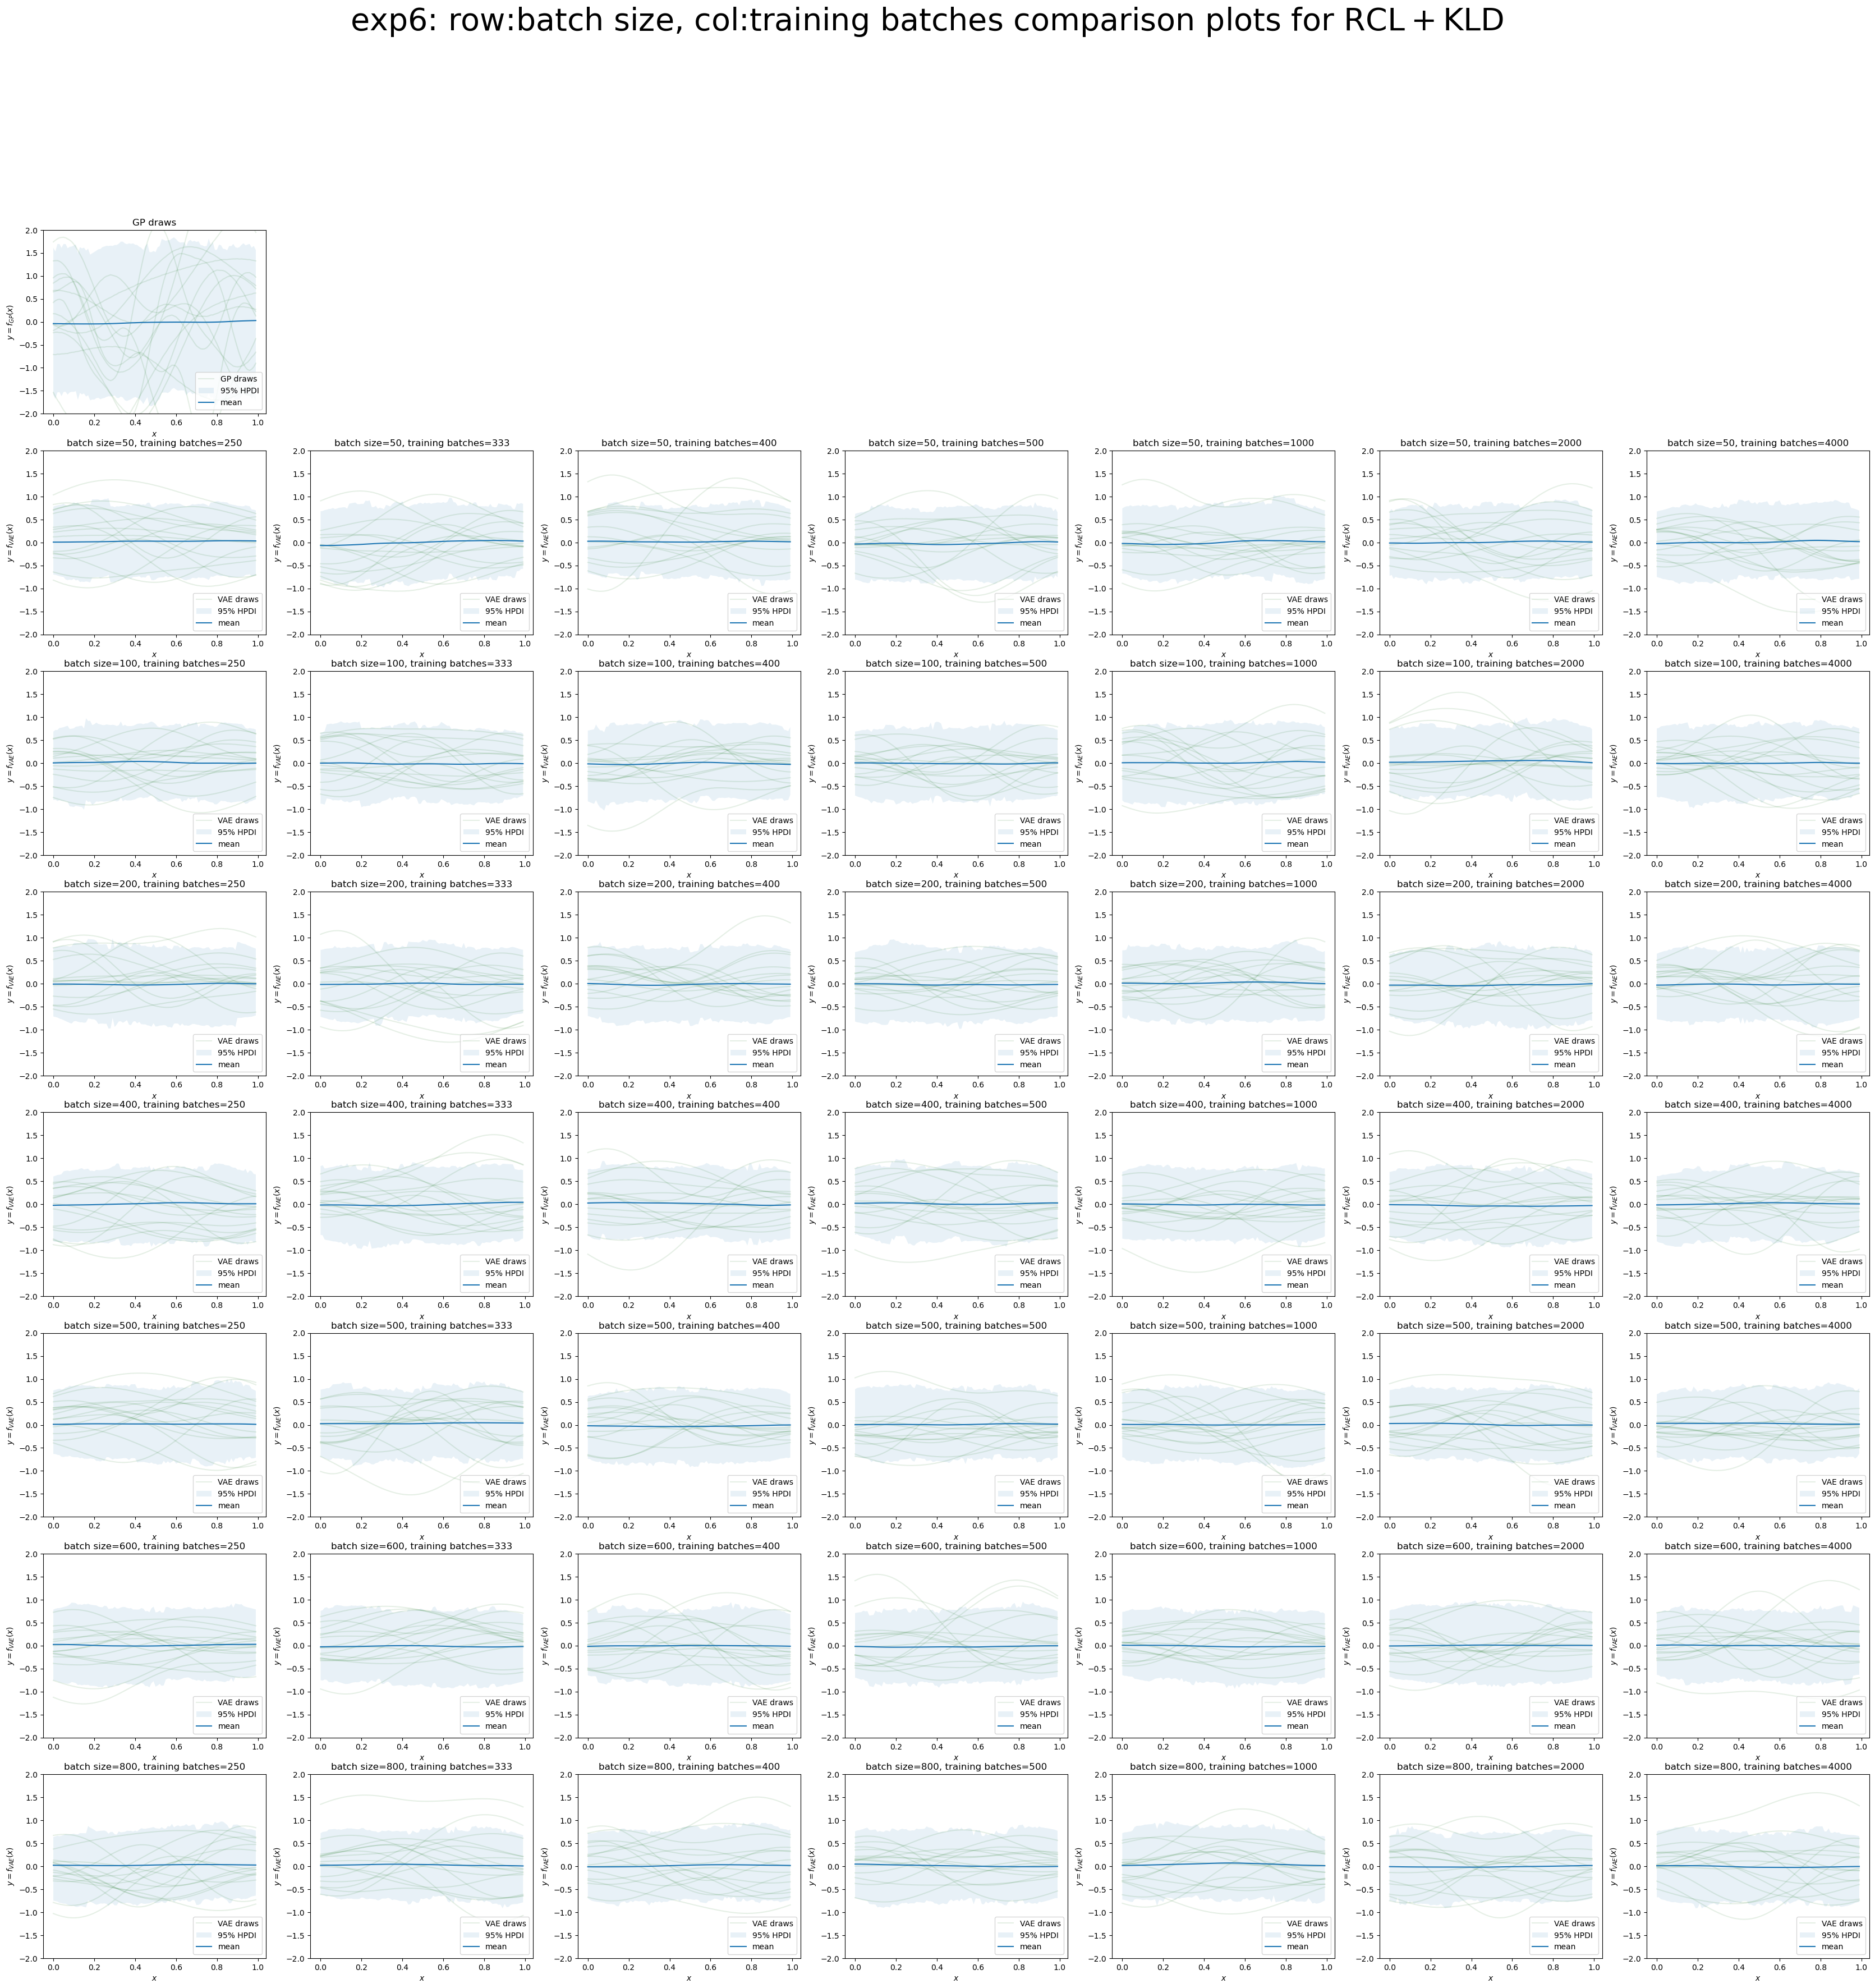

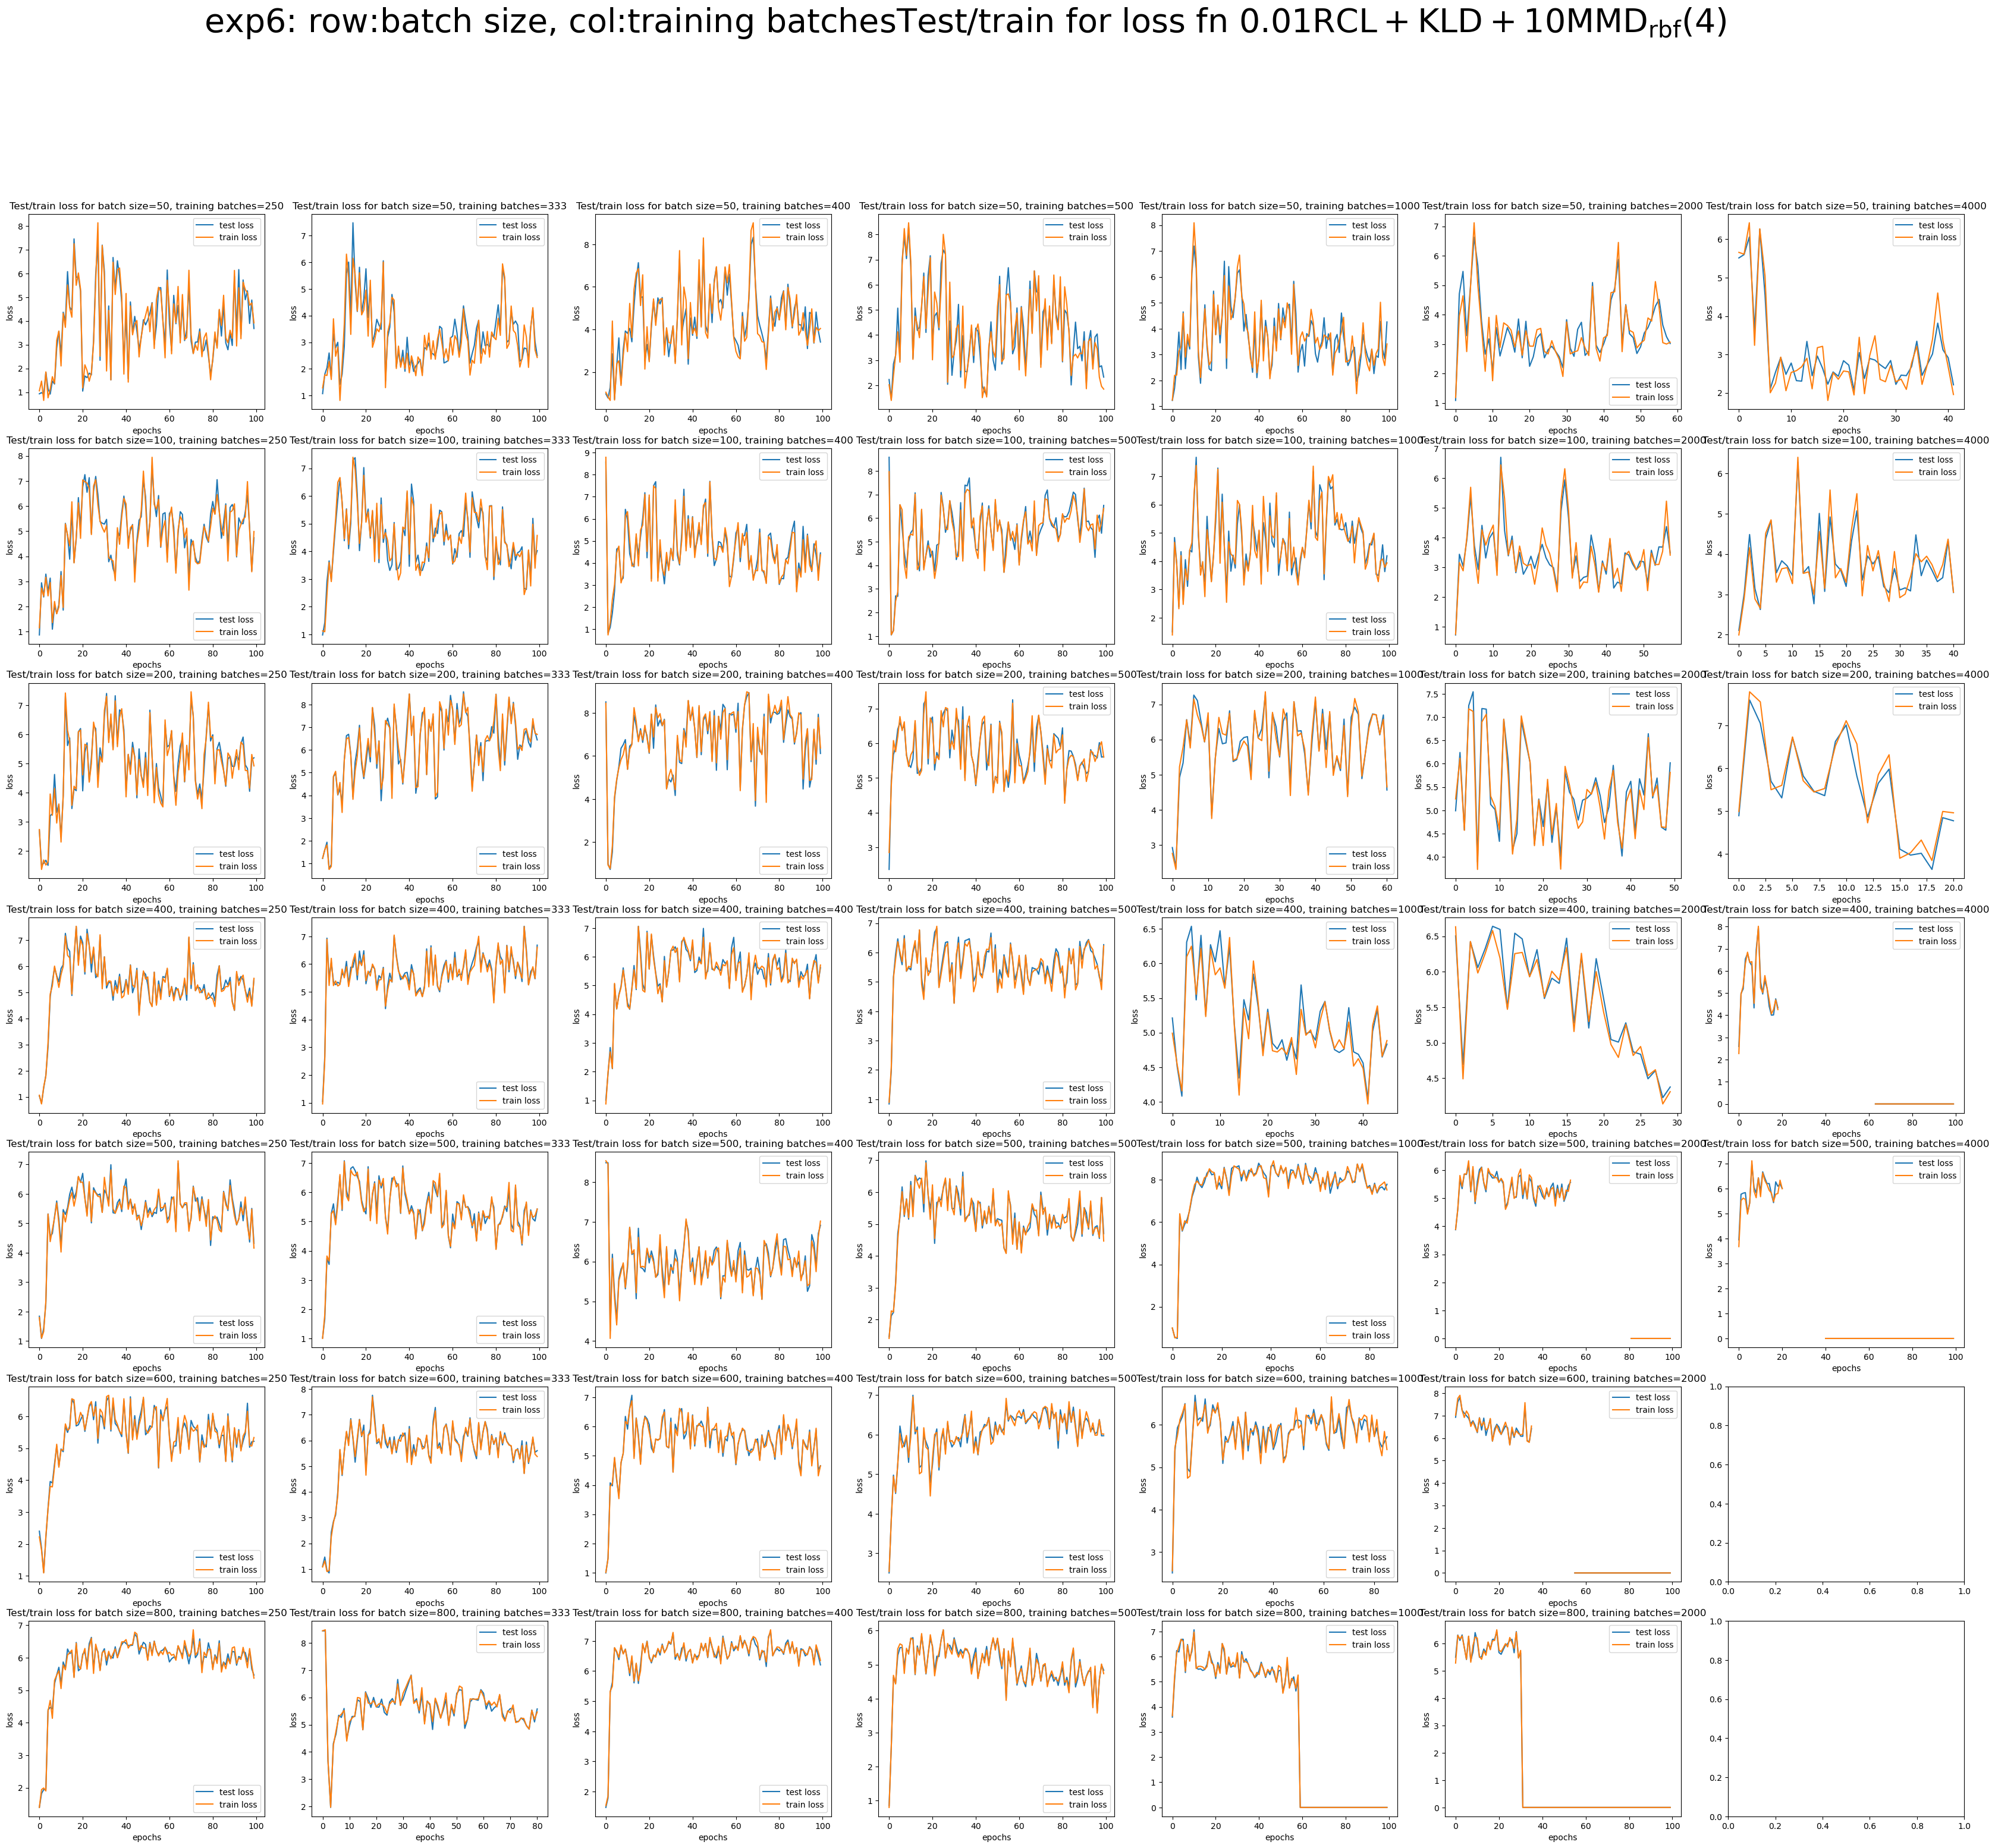

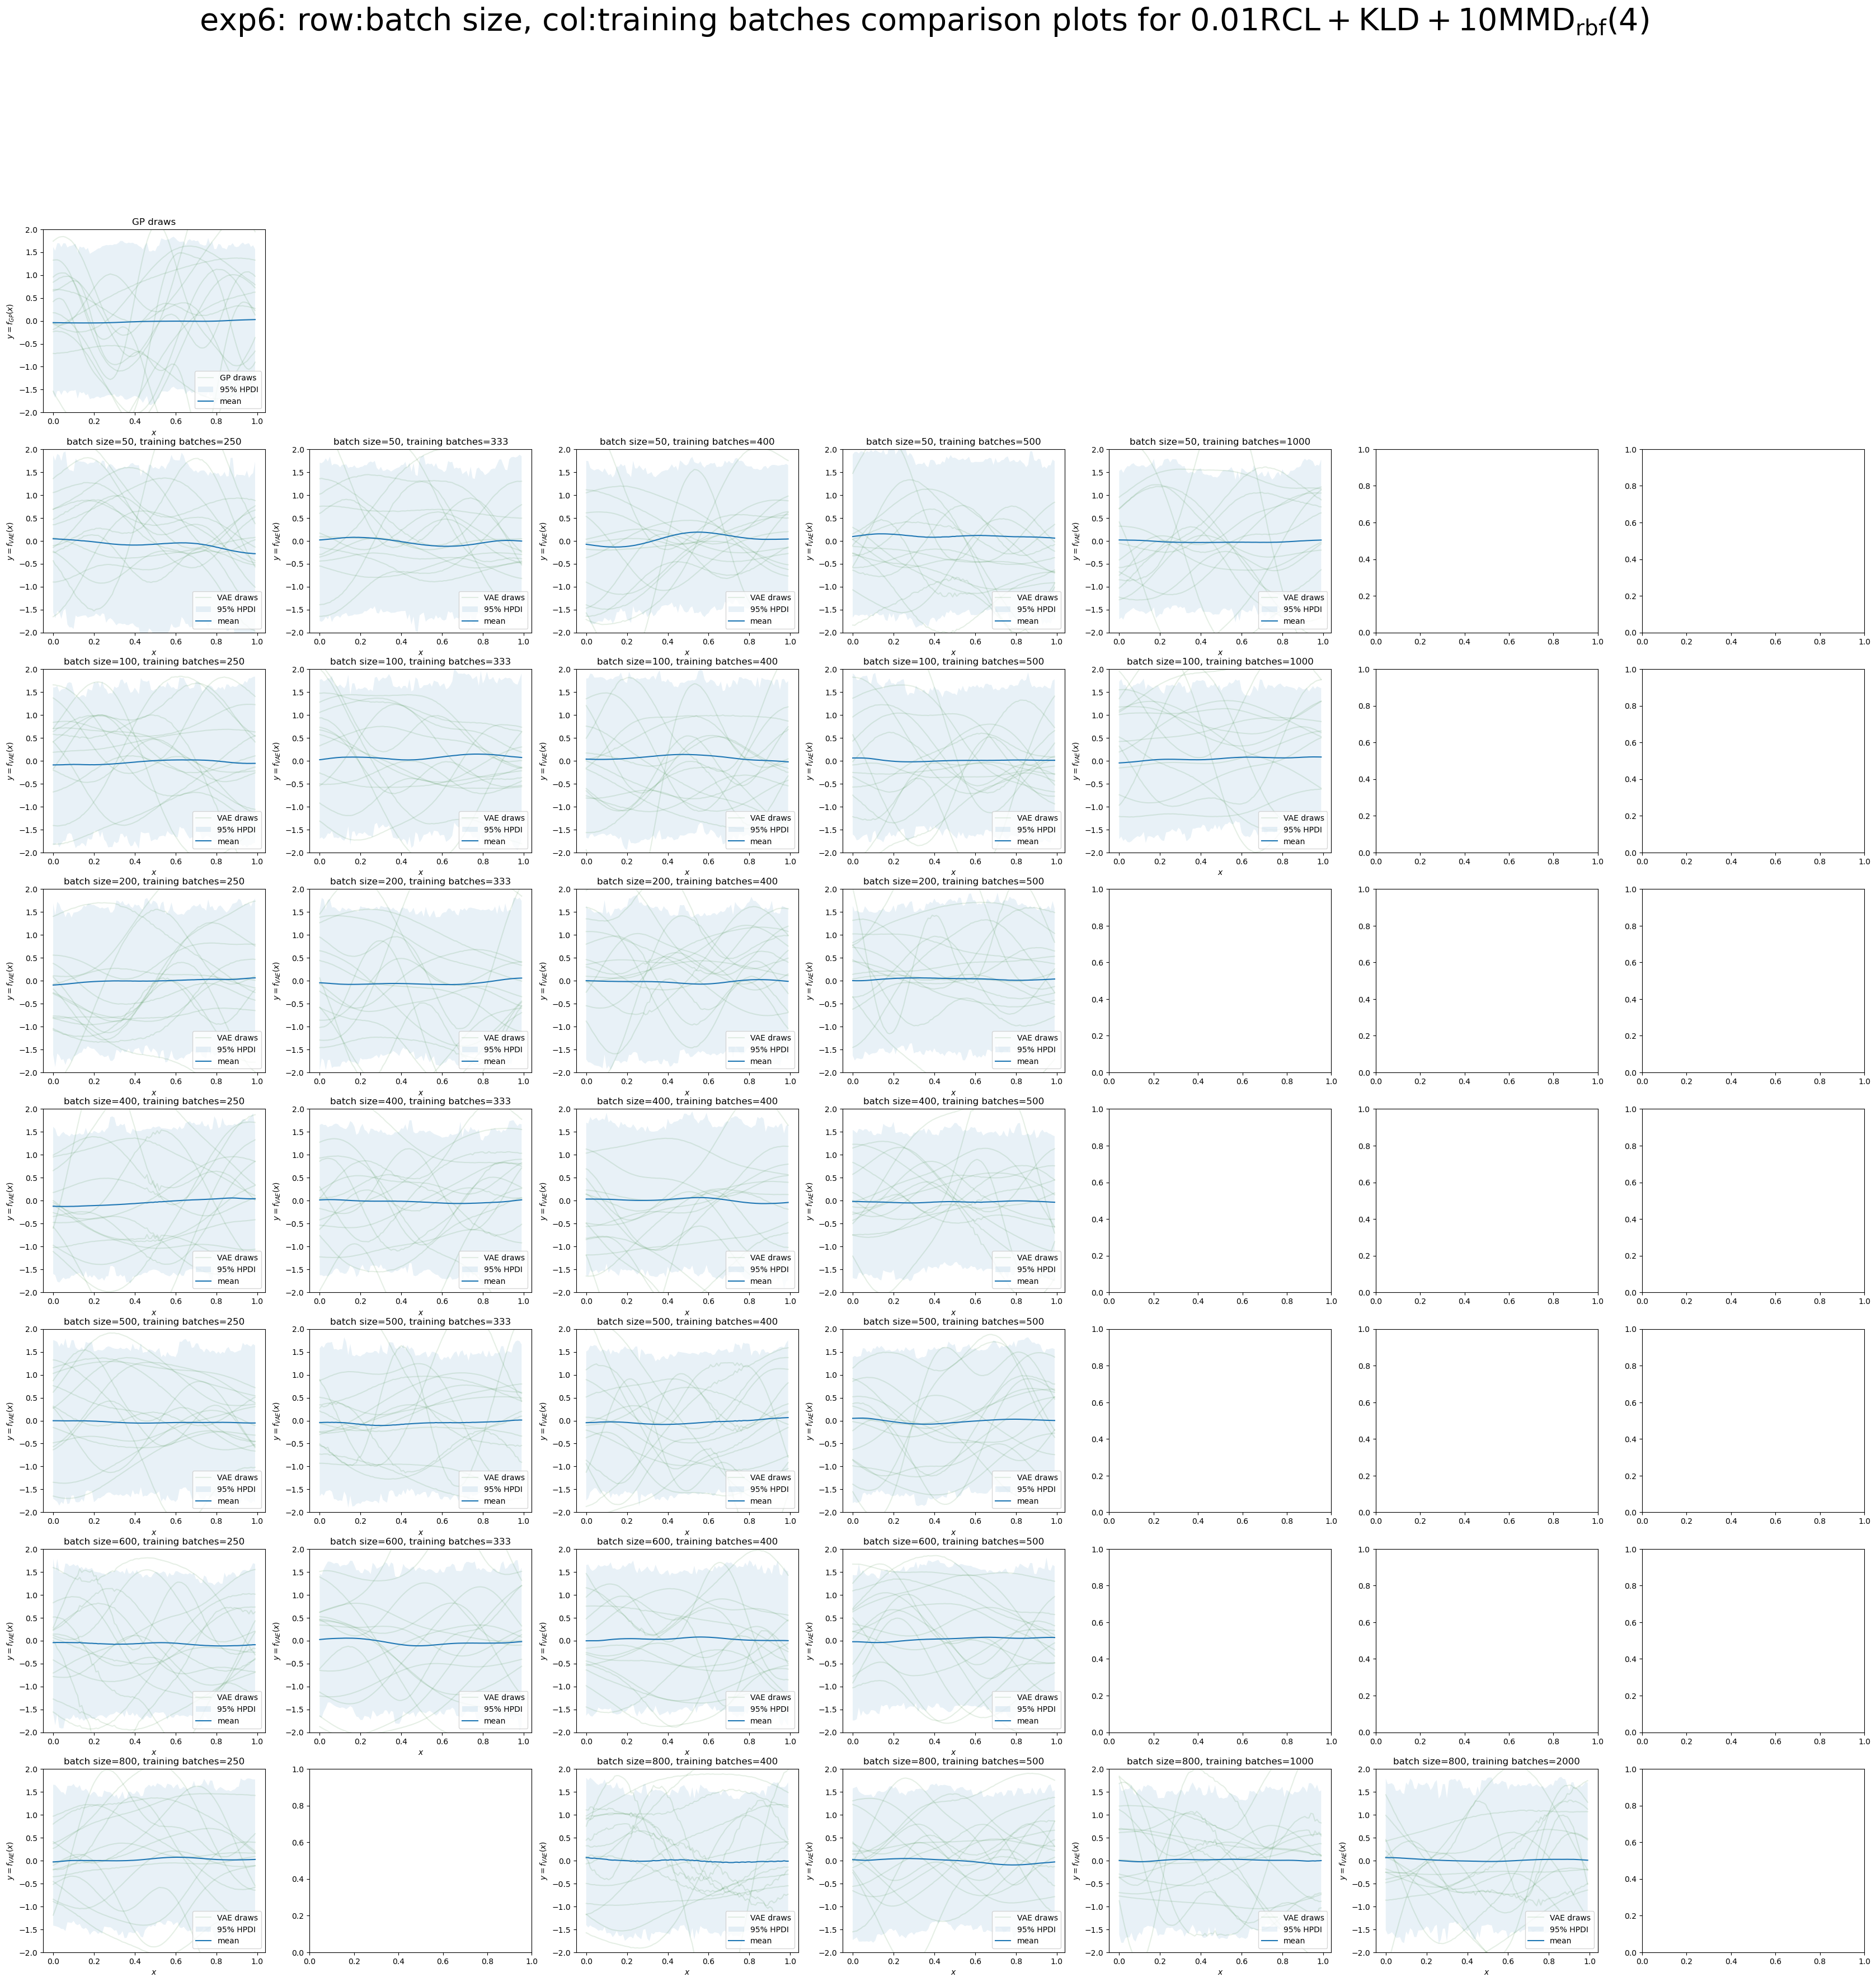

In [52]:

#plot_experiment("exp5", "1")
plot_experiment("exp6", "1")
# plot_experiment("exp7", "7")
#plot_experiment("exp8", "1")
#plot_experiment("exp9", "1")


In [8]:
def plot_experiment_scores(experiment, count, outlier_bounds = None):
    temp_args = load_args("11", count, experiment)

    exp_args = temp_args[experiment]
    aL = len(exp_args["Arange"])

    for loss_fn in temp_args["loss_fns"]:
        pretty_lf = pretty_loss_fn_name(loss_fn)

        prettyAdesc = pretty_label(exp_args["Adesc"])
        prettyBdesc = pretty_label(exp_args["Bdesc"])

        scores = []

        for i, a in enumerate(exp_args["Arange"]):
            ss = []
            for j, b in enumerate(exp_args["Brange"]):
                args = load_args("11", count, experiment)

                args = update_args_11(args, args[experiment], i, j)

                index = i + j * aL

                try:
                    s = load_scores("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))
                    if index ==42 and loss_fn != "RCL+KLD":
                        print(jnp.mean(jnp.array(s["frobenius"])), jnp.array(s["frobenius"]))
                    new_s = {
                        "frobenius": jnp.mean(jnp.array(s["frobenius"])),
                        "moments_diff": jnp.mean(
                            jnp.abs(jnp.mean(jnp.array(s["vae_moments"]) - jnp.array(s["gp_moments"]), axis=1))
                        ),
                        "mmd": jnp.sum(jnp.array([x[1] for x in s["mmd"]])),
                    }

                

                    ss.append(new_s)

                except FileNotFoundError:
                    ss.append({"frobenius": onp.nan, "moments_diff": onp.nan, "mmd": onp.nan, "interrupted": True})
                    print(f"Failed to load a={a}, b={b}")
            scores.append(ss)

        to_plot =  ["frobenius", "moments_diff", "mmd"]
        
        interrupted = onp.array([["interrupted" in cell for cell in row] for row in scores])
        scores = [onp.array([[cell[t] for cell in row] for row in scores])  for t in to_plot]

        for i,t in enumerate(to_plot):

            plot_times_matrix(
                onp.ma.array(scores[i], mask=interrupted),
                
                exp_args["Arange"],
                exp_args["Brange"],
                prettyAdesc,
                prettyBdesc,
                f"{experiment}: {pretty_lf}, {t}",
                save_path=f"./gen_plots/11/11_{experiment}_{loss_fn}_{t}_matrix.png",
                upper_limit=outlier_bounds[i] if outlier_bounds is not None else None
            )


Failed to load a=1600, b=100
Failed to load a=1600, b=200
Failed to load a=1600, b=400
Failed to load a=1600, b=800
Failed to load a=3200, b=100
Failed to load a=3200, b=200
Failed to load a=3200, b=400
Failed to load a=3200, b=800
Failed to load a=6400, b=100
Failed to load a=6400, b=200
Failed to load a=6400, b=400
Failed to load a=6400, b=800


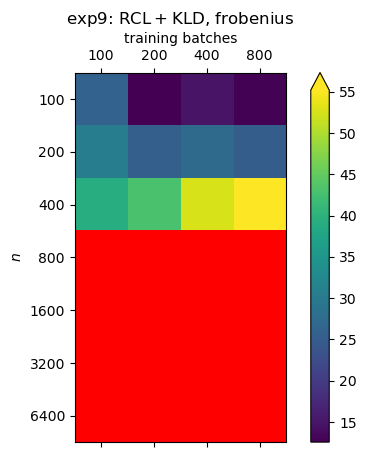

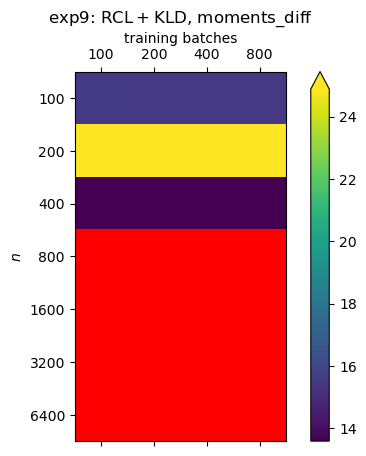

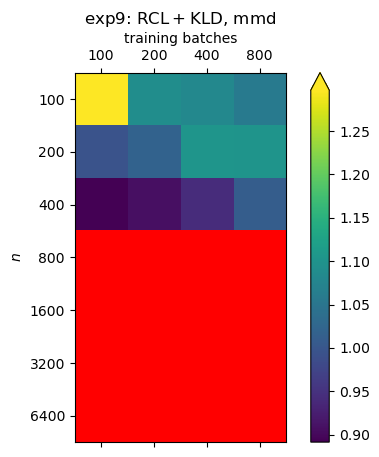

In [13]:
plot_experiment_scores("exp9", "1") #, [20, 40, 5])